# Overview

Create a simple baseline model to compare more advanced methods against.

### Ideas based on EDA

**Categorical variables as primary predictors:**
- Take one or a combination of variables and calculate the average salary per category

Predicting salaries on new data will be made by joining the calculated grouped averages, by using the group of categorical variables as the key. 


**Numerical variables as additive predictors:**

The baseline model will require at least one categorical variable. Models using just a numerical variable for prediction will not be tested here. To illustrate why this decision was made, consider taking the average salary of all jobs within 1 `milesFromMetropolis`, for example. This will include a mixture of all different levels of `jobTypes` and will likely not give a good estimate. Because the average value would be taking into account roles ranging from `JANITOR` to `CEO`.

Instead, the numerical variables will be used as an additive value to the average salary that was calculated with the categorical variable(s).



___

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from src.Baseline import BaselineModel, TestModels
from src.baseline_utils import visualize_numeric_fit

# Load data

In [2]:
train_salaries = pd.read_csv("../data/interim/salaries_train_85_15_split.csv", index_col = 0)
test_salaries = pd.read_csv("../data/interim/salaries_test_85_15_split.csv", index_col = 0)

print(f"training set shape: {train_salaries.shape}")
print(f"test set shape: {test_salaries.shape}")

training set shape: (849995, 8)
test set shape: (150000, 8)


# Example baseline model to illustrate functionality

## Fitting the model

The model is instantiated with `BaselineModel()` and is fit using the `.fit()` method, passing in a dataframe.

- args:
    + category_vars (required): String or list of strings of categorical variables
    + numeric_vars (optional): String or list of strings of numerical variables
    + id_var (optional): Name of the ID column - set to 'jobId' by default
    + target (optional): Name of the target variable - set to 'salary' by default 

In [3]:
example_baseline = BaselineModel(category_vars='jobType', numeric_vars=['yearsExperience', 'milesFromMetropolis'])
example_baseline.fit(train_salaries)

#### Fitted categorical values

- Stored as a dataframe with one column: `salary_preds`  
- The index is the grouping variable used for calculating the average salary
    + For multiple categorical variables the index will be multi-leveled

In [4]:
example_baseline.fitted_category_salaries

,salary_preds
jobType,
JANITOR,70.785181
JUNIOR,95.341564
SENIOR,105.405757
MANAGER,115.419110
VICE_PRESIDENT,125.390156
CFO,135.441672
CTO,135.485534
CEO,145.364115


#### Fitted numerical values

- Stored as a dictionary with a key for each numerical column that was used for fitting  
- The value of each key contains a Series that represents, for each unique value, the difference between the average salary of that value and the overall average salary 

In [5]:
example_baseline.fitted_numeric_salaries

{'yearsExperience': yearsExperience
 0    -24.173570
 1    -22.052242
 2    -19.969124
 3    -18.064561
 4    -16.023098
 5    -14.395663
 6    -12.127425
 7     -9.997218
 8     -8.301810
 9     -5.921390
 10    -3.938727
 11    -2.166129
 12     0.444267
 13     1.857557
 14     4.233491
 15     5.923825
 16     8.032665
 17     9.979064
 18    12.310572
 19    13.831090
 20    16.160942
 21    18.112413
 22    20.266673
 23    22.328628
 24    24.114106
 Name: yearsExperience_diff, dtype: float64,
 'milesFromMetropolis': milesFromMetropolis
 0     19.276701
 1     19.659869
 2     19.054796
 3     18.436109
 4     18.819768
         ...    
 95   -18.044574
 96   -18.752739
 97   -18.601879
 98   -18.841883
 99   -20.292592
 Name: milesFromMetropolis_diff, Length: 100, dtype: float64}

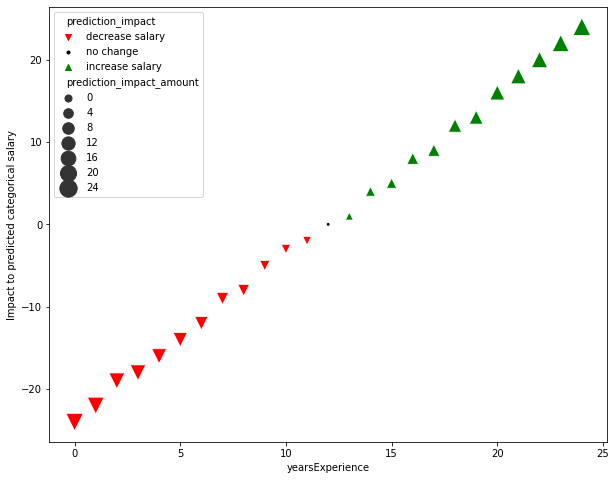

In [6]:
visualize_numeric_fit(example_baseline.fitted_numeric_salaries['yearsExperience'])

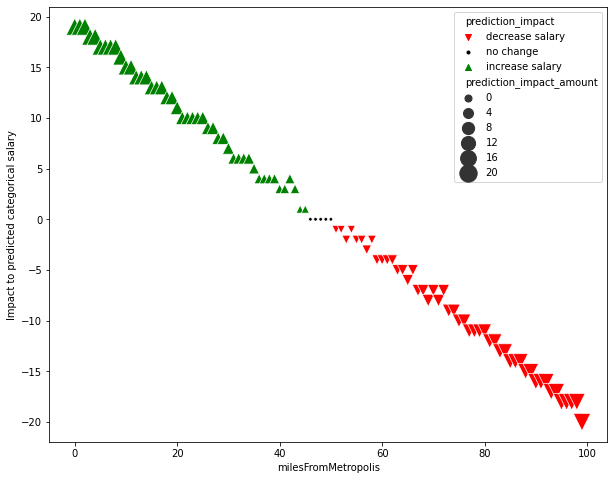

In [7]:
visualize_numeric_fit(example_baseline.fitted_numeric_salaries['milesFromMetropolis'])

## Final prediction process

In [8]:
# Make salary predictions on the test set
example_preds = example_baseline.predict(test_salaries, return_all_cols=True)

In [9]:
interesting_cols = ['jobType', 'yearsExperience', 'milesFromMetropolis',
                    'yearsExperience_diff', 'milesFromMetropolis_diff',
                    'category_preds_tmp', 'sum_numeric_diff', 'preds_with_sum', 'salary']
example_preds = example_preds[interesting_cols]

col_rename = {
    'sum_numeric_diff': 'combined_diff',
    'category_preds_tmp': 'category_preds',
    'preds_with_sum': 'final_preds',
    'salary': 'salary_actual'
}
example_preds.rename(columns = col_rename, inplace = True)

# Inspect some random examples
example_preds.sample(5, random_state = 50)

,jobType,yearsExperience,milesFromMetropolis,yearsExperience_diff,milesFromMetropolis_diff,category_preds,combined_diff,final_preds,salary_actual
443822,JANITOR,3,15,-18.064561,13.599846,70.785181,-4.464715,66.320466,78
417907,CEO,17,50,9.979064,-0.567644,145.364115,9.411420,154.775536,206
165074,CTO,6,68,-12.127425,-7.143497,135.485534,-19.270922,116.214612,126
617693,MANAGER,13,89,1.857557,-15.506759,115.419110,-13.649202,101.769908,73
338229,JUNIOR,4,32,-16.023098,6.610019,95.341564,-9.413079,85.928484,101


# Find best baseline model parameters

#### All combinations of categorical variables

In [10]:
category_vars = ['jobType', 'degree', 'major', 'industry']

category_combos = []
for i in range(1,5):
    combos = combinations(category_vars, i)
    for j in combos:
        category_combos.append(list(j))

print(f"There are {len(category_combos)} combinations of categorical variables")
category_combos

There are 15 combinations of categorical variables


[['jobType'],
 ['degree'],
 ['major'],
 ['industry'],
 ['jobType', 'degree'],
 ['jobType', 'major'],
 ['jobType', 'industry'],
 ['degree', 'major'],
 ['degree', 'industry'],
 ['major', 'industry'],
 ['jobType', 'degree', 'major'],
 ['jobType', 'degree', 'industry'],
 ['jobType', 'major', 'industry'],
 ['degree', 'major', 'industry'],
 ['jobType', 'degree', 'major', 'industry']]

The values of the `model_variations` dictionary get passed to `BaselineModel()`. Each combination of categorical variables will therefore have multiple variations evaluated.

The variations:
- **only_categorical**: No numeric variables used for fitting, predictions will be made only with grouped categorical averages
- **add_yearsExperience**: The `yearsExperience` variable is used for fitting and added to the categorical average
- **add_milesFromMetropolis**: The `milesFromMetropolis` variable is used for fitting and added to the categorical average
- **add_both**: Both of the above numeric variables are used and the relative differences are combined and added to the categorical average
    + there are two models created for this variation. One combining the numeric fitted values using `sum`, and the other using `mean`

Best model score: 371.221955706675

Best model parameters:
{'category_vars': ['jobType', 'degree', 'major', 'industry'], 'numeric_vars': ['yearsExperience', 'milesFromMetropolis'], 'numeric_combo': 'sum'}





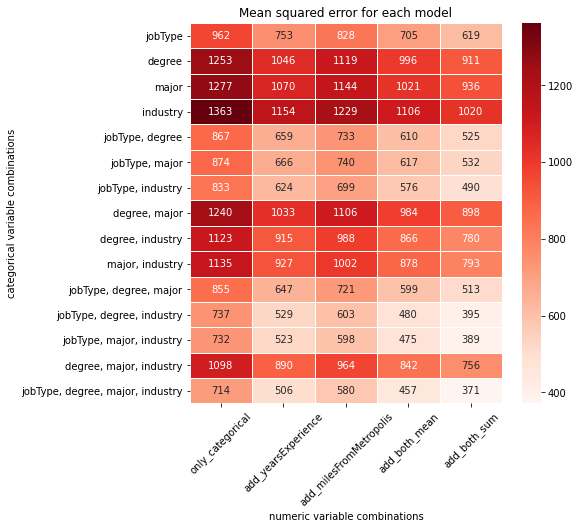

In [11]:
model_variations = {
    'only_categorical': None,
    'add_yearsExperience': 'yearsExperience',
    'add_milesFromMetropolis': 'milesFromMetropolis',
    'add_both': ['yearsExperience', 'milesFromMetropolis']
}
best_model_test = TestModels(train_salaries, test_salaries, category_combos, model_variations)

#### Sanity check the best baseline model, check the residuals and see how often the numerical variable addition helped vs not

In [ ]:
best_baseline = best_model_test.best_model

### insights from best baseline model

in each of the combinations where `jobType` is missing, the MSE is higher than combinations where it is

Interestingly, `industry` when used as a single categorical variable predictor is the worst among any other single categorical predictor. But when it is combined with `jobType` then the two variables together are the best among all two-category combinations



In [13]:
best_model.best_model.variables_for_fitting

['jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis']